In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np

/Users/david.fischer/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=0, num_confounders=2)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

# count data
X = sim.X
# sample description
sample_description = sim.sample_description

The sample description should be a pandas DataFrame with `num_observations` rows.
Each column should represent a property of the dataset.

The module `batchglm.api.data` contains some helper functions which can be useful to create this sample description:

- `sample_description_from_anndata()`
- `sample_description_from_xarray()`

In [3]:
sample_description.iloc[:10,:]

,condition
observations,
0,0
1,1
2,0
3,1
4,0
5,1
6,0
7,1
8,0


# Run differential expression test:

The t-test checks if two groups of samples differ significantly in one gene.

Therefore, it has to be provided with a parameter `grouping` which specifies the group membership of each sample.
It can be either the name of a column in `sample_description` or a vector of length `num_observations`.


In [4]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.t_test(
    data=X,
    grouping="condition",
    sample_description=sample_description
)


# Obtaining the results

The p-/q-values can be obtained by calling test.pval / test.qval:

In [5]:
test.qval

array([2.10277135e-02, 8.20856348e-01, 9.12846381e-01, 6.97139750e-02,
       1.41999749e-01, 8.24798671e-01, 2.82543994e-01, 8.24798671e-01,
       8.59918197e-13, 3.40828738e-04, 4.65052876e-01, 0.00000000e+00,
       5.00100815e-07, 4.96696701e-11, 4.18414153e-08, 2.70359011e-06,
       1.53119441e-02, 0.00000000e+00, 0.00000000e+00, 2.40178248e-11,
       4.67447229e-02, 1.62636409e-02, 3.11399905e-01, 8.24798671e-01,
       4.99951388e-06, 4.82830072e-09, 4.04524435e-02, 5.44061273e-01,
       2.75566175e-05, 8.79614070e-08, 1.87052954e-01, 6.39139535e-11,
       2.23402040e-05, 9.56456467e-02, 7.19543209e-02, 5.01848613e-01,
       1.43601987e-02, 1.24458723e-05, 1.66700502e-04, 6.74509679e-02,
       0.00000000e+00, 3.22416950e-03, 6.01493337e-04, 2.23402040e-05,
       8.24798671e-01, 7.15076728e-01, 9.80325384e-03, 9.25023623e-01,
       4.99951388e-06, 3.01176473e-02, 7.42892691e-02, 8.88389228e-02,
       3.82210379e-03, 3.31219189e-03, 0.00000000e+00, 9.09414653e-05,
      

test.summary() returns a pandas DataFrame with a quick overview of the test results:

In [6]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,0,1.198580e-02,2.102771e-02,0.072024,8149.4485,False,False
1,1,7.469793e-01,8.208563e-01,0.007668,7896.4400,False,False
2,2,8.945895e-01,9.128464e-01,0.008174,2795.0375,False,False
3,3,4.601122e-02,6.971398e-02,-0.092609,171.9665,False,False
4,4,1.008198e-01,1.419997e-01,-0.029883,4435.1100,False,False
5,5,7.730207e-01,8.247987e-01,-0.012451,5171.3490,False,False
6,6,2.203843e-01,2.825440e-01,0.036231,2716.0680,False,False
7,7,7.918067e-01,8.247987e-01,-0.014766,3287.3135,False,False
8,8,9.459100e-14,8.599182e-13,-0.214733,31.5345,False,False
9,9,1.295149e-04,3.408287e-04,-0.088745,3708.1990,False,False


- `gene`: gene name / identifier
- `pval`: p-value of the gene
- `qval`: multiple testing - corrected p-value of the gene
- `log2fc`: log_2 fold change between `no coefficient` and `coefficient`

You can also directly subset the summary table. Here, we are only interested in genes with a multiple testing corrected p-value <= 0.05 and which are upregulared (fold change >= 1).

In [11]:
test.summary(qval_thres=0.05, fc_upper_thres=1).iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,0,1.198580e-02,2.102771e-02,0.072024,8149.4485,False,False
11,11,4.940656e-324,0.000000e+00,0.243166,1168.1220,False,False
15,15,6.758975e-07,2.703590e-06,0.160034,10320.9600,False,False
16,16,8.115330e-03,1.531194e-02,0.075769,3843.4300,False,False
19,19,2.882139e-12,2.401782e-11,0.173797,10038.6815,False,False
24,24,1.349869e-06,4.999514e-06,0.135410,9476.5440,False,False
25,25,7.242451e-10,4.828301e-09,0.202496,8073.3025,False,False
26,26,2.508051e-02,4.045244e-02,0.062277,6275.9930,False,False
28,28,9.369250e-06,2.755662e-05,0.092570,3230.8400,False,False
37,37,3.733762e-06,1.244587e-05,0.198883,5736.7460,False,False


`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c23930dd8>)

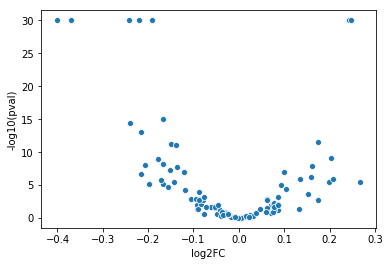

In [8]:
test.plot_volcano()